In [ ]:
# download dataset 
import os
import zipfile

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"]="/content/drive/MyDrive/Kaggle"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 93% 209M/225M [00:01<00:00, 157MB/s]
100% 225M/225M [00:01<00:00, 139MB/s]


In [ ]:
Zip = zipfile.ZipFile("/content/flowers-recognition.zip")
Zip.extractall("/tmp")
Zip.close()

In [ ]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten,Conv2D
from tensorflow.keras.models import Sequential
import os
import PIL
import cv2
from PIL import Image
import sys


In [ ]:
data_directory ="/tmp/flowers"

In [ ]:
print(os.listdir("/tmp/flowers"))

['tulip', 'dandelion', 'sunflower', 'daisy', 'rose']


In [ ]:
# Load using keras.preprocessing

# Create a dataset

# Defining parameters for the loader

batch_size = 32
img_height = 180
img_width = 180


In [ ]:
# It's good practice to use a validation split when developing your model. Let's use 75% of the images for training, and 25% for validation.

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_directory,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 3238 files for training.


In [ ]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_directory,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 1079 files for validation.


In [ ]:
# we can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.
class_names = train_dataset.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


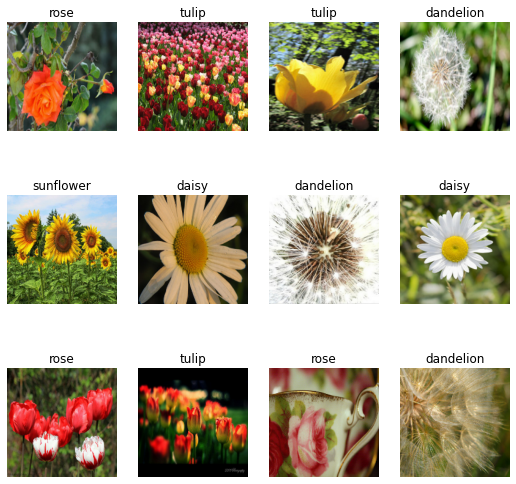

In [ ]:
# Visualize the data:
# Here are the first 12 images from the training dataset.

import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
# Configure the dataset for performance:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Standardize the data
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# There are two ways to use this layer. You can apply it to the dataset by calling map:

normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0143791055 0.9679742


In [ ]:
# Create the model
num_classes = 5
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
# Compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Train the model
epochs=10
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/10
102/102 [==============================] - 113s 1s/step - loss: 1.2967 - accuracy: 0.4413 - val_loss: 1.1711 - val_accuracy: 0.4801
Epoch 2/10
102/102 [==============================] - 110s 1s/step - loss: 1.0263 - accuracy: 0.5951 - val_loss: 0.9420 - val_accuracy: 0.6219
Epoch 3/10
102/102 [==============================] - 112s 1s/step - loss: 0.9137 - accuracy: 0.6507 - val_loss: 0.9379 - val_accuracy: 0.6219
Epoch 4/10
102/102 [==============================] - 110s 1s/step - loss: 0.8256 - accuracy: 0.6887 - val_loss: 0.9386 - val_accuracy: 0.6293
Epoch 5/10
102/102 [==============================] - 110s 1s/step - loss: 0.7619 - accuracy: 0.7097 - val_loss: 0.9070 - val_accuracy: 0.6608
Epoch 6/10
102/102 [==============================] - 110s 1s/step - loss: 0.6152 - accuracy: 0.7650 - val_loss: 0.9548 - val_accuracy: 0.6469
Epoch 7/10
102/102 [==============================] - 110s 1s/step - loss: 0.4700 - accuracy: 0.8240 - val_loss: 0.9815 - val_accuracy: 0.6701

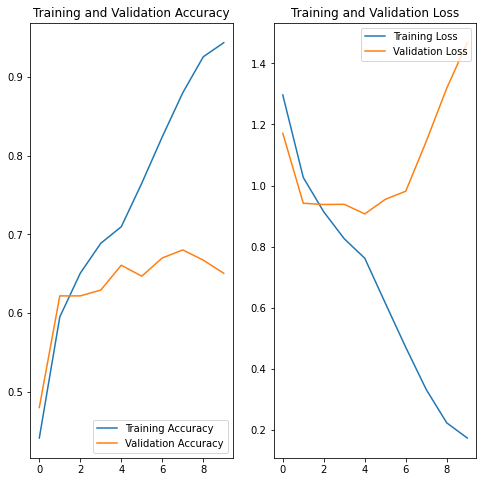

In [ ]:
# Visualize training results:

# Create plots of loss and accuracy on the training and validation sets.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Overfitting:
# Data augmentation:

#You will implement data augmentation using the layers from tf.keras.layers.experimental.preprocessing.
#These can be included inside your model like other layers, and run on the GPU.

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)



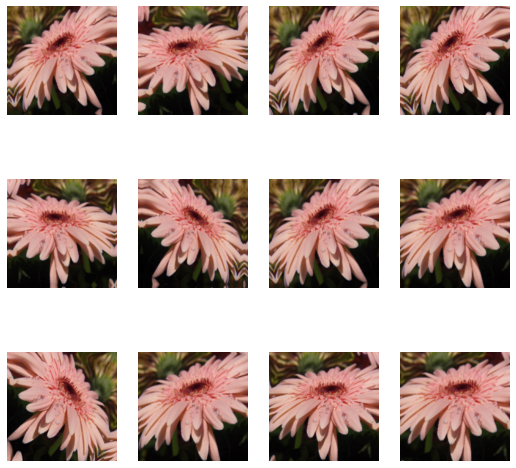

In [ ]:
# Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

plt.figure(figsize=(9, 9))
for images, _ in train_dataset.take(1):
  for i in range(12):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Dropout:
# Let's create a new neural network using layers.Dropout, then train it using augmented images.

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)


Epoch 1/10
102/102 [==============================] - 113s 1s/step - loss: 1.3512 - accuracy: 0.4246 - val_loss: 1.1280 - val_accuracy: 0.5338
Epoch 2/10
102/102 [==============================] - 112s 1s/step - loss: 1.0693 - accuracy: 0.5942 - val_loss: 1.1235 - val_accuracy: 0.5412
Epoch 3/10
102/102 [==============================] - 112s 1s/step - loss: 1.0046 - accuracy: 0.6127 - val_loss: 0.9877 - val_accuracy: 0.6043
Epoch 4/10
102/102 [==============================] - 111s 1s/step - loss: 0.9246 - accuracy: 0.6436 - val_loss: 0.9371 - val_accuracy: 0.6367
Epoch 5/10
102/102 [==============================] - 111s 1s/step - loss: 0.8745 - accuracy: 0.6668 - val_loss: 0.9069 - val_accuracy: 0.6571
Epoch 6/10
102/102 [==============================] - 112s 1s/step - loss: 0.8313 - accuracy: 0.6711 - val_loss: 0.8509 - val_accuracy: 0.6691
Epoch 7/10
102/102 [==============================] - 111s 1s/step - loss: 0.8045 - accuracy: 0.6912 - val_loss: 0.8114 - val_accuracy: 0.6914

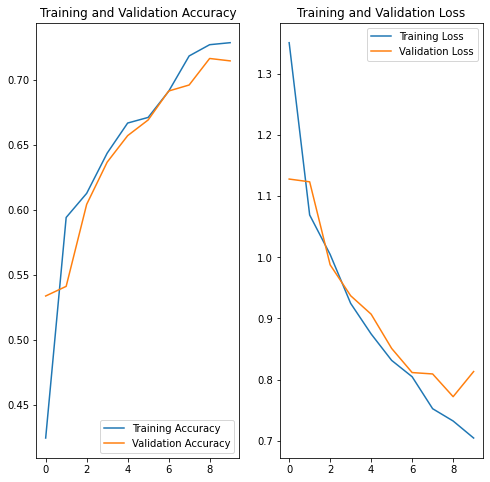

In [ ]:
# Visualize training results
# After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
THE END